In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential, load_model
from scipy.stats import pearsonr, spearmanr, ttest_1samp, ttest_ind_from_stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
from regression_model import pearson_correlation
rcParams.update({'figure.autolayout': True})
rcParams['svg.fonttype'] = 'none'
rcParams['font.size']=15
import keras.metrics
keras.metrics.pearson_correlation = pearson_correlation

Using Theano backend.
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/home/eramamur/bin/miniconda3/envs/gpu_keras_theano/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 227, in <module>
    use(config.device)
  File "/home/eramamur/bin/miniconda3/envs/gpu_keras_theano/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "/home/eramamur/bin/miniconda3/envs/gpu_keras_theano/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 99, in init_dev
    **args)
  File "pygpu/gpuarray.pyx", line 658, in pygpu.gpuarray.init
  File "pygpu/gpuarray.pyx", line 587, in pygpu.gpuarray.pygpu_init
pygpu.gpuarray.GpuArrayException: b'Could not load "libcuda.so": libcuda.so: cannot open shared object file: No such file or directory'


In [2]:
model = load_model('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/model_1_w167.hdf5')

In [10]:
tewhey_ref_sequences = np.load("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_one_hot_encoded_ref_sequences_w167.npy")
tewhey_alt_sequences = np.load("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_one_hot_encoded_alt_sequences_w167.npy")

In [13]:
ref_scores = model.predict(tewhey_ref_sequences)
alt_scores = model.predict(tewhey_alt_sequences)

In [14]:
tewhey_snp_info = pd.read_csv("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_snps_data_extended_joined_to_1kg_mappings_with_1kb_snp_centered_sequences_with_gm_overlaps.txt",
                              sep="\t")

In [15]:
tewhey_snp_info["Ref.score"] = ref_scores
tewhey_snp_info["Alt.score"] = alt_scores
tewhey_snp_info["Predicted.skew"] = np.log2(tewhey_snp_info["Alt.score"]) - np.log2(tewhey_snp_info["Ref.score"])

Reference Sequences: (0.2489206115813629, 0.0)
Reference Sequences: SpearmanrResult(correlation=0.16426921152310828, pvalue=1.0654368220202721e-236)
Alternate Sequences: (0.24878699239933857, 0.0)
Alternate Sequences: SpearmanrResult(correlation=0.16232399140182932, pvalue=4.21303661543577e-231)


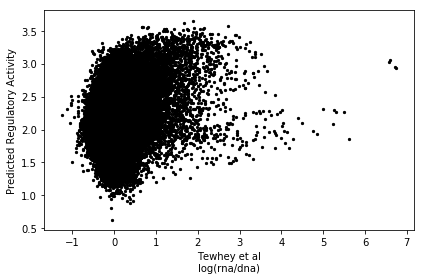

In [17]:
plt.scatter(tewhey_snp_info["C.B.log2FC"], np.log2(tewhey_snp_info["Alt.score"]), c='k', s=5)
plt.scatter(tewhey_snp_info["C.A.log2FC"], np.log2(tewhey_snp_info["Ref.score"]), c='k', s=5)
plt.xlabel("Tewhey et al\nlog(rna/dna)")
plt.ylabel("Predicted Regulatory Activity")

print("Reference Sequences:",pearsonr(np.nan_to_num(tewhey_snp_info["C.A.log2FC"]), np.log2(tewhey_snp_info["Ref.score"])))
print("Reference Sequences:",spearmanr(np.nan_to_num(tewhey_snp_info["C.A.log2FC"]), np.log2(tewhey_snp_info["Ref.score"])))
print("Alternate Sequences:",pearsonr(np.nan_to_num(tewhey_snp_info["C.B.log2FC"]), np.log2(tewhey_snp_info["Alt.score"])))
print("Alternate Sequences:",spearmanr(np.nan_to_num(tewhey_snp_info["C.B.log2FC"]), np.log2(tewhey_snp_info["Alt.score"])))

(0.1038839404370012, 4.229786824089867e-95)
SpearmanrResult(correlation=0.0707263991369296, pvalue=6.150580641513683e-45)


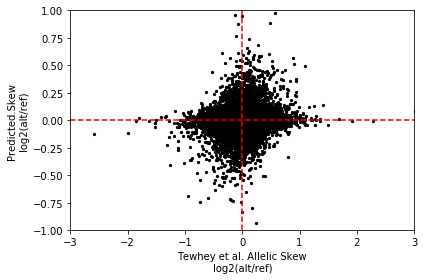

In [18]:
plt.scatter(tewhey_snp_info["LogSkew.Comb"],tewhey_snp_info["Predicted.skew"] , c = 'k', s=5)
plt.axhline(y=0, c='r', linestyle='--')
plt.axvline(x=0, c='r', linestyle='--')
plt.xlim([-3,3])
plt.ylim([-1,1])
plt.xlabel("Tewhey et al. Allelic Skew\nlog2(alt/ref)")
plt.ylabel("Predicted.Skew\nlog2(alt/ref)")
print(pearsonr(np.nan_to_num(tewhey_snp_info["LogSkew.Comb"]), tewhey_snp_info["Predicted.skew"]))
print(spearmanr(np.nan_to_num(tewhey_snp_info["LogSkew.Comb"]), tewhey_snp_info["Predicted.skew"]))

(0.1038839404370012, 4.229786824089867e-95)
SpearmanrResult(correlation=0.0707263991369296, pvalue=6.150580641513683e-45)


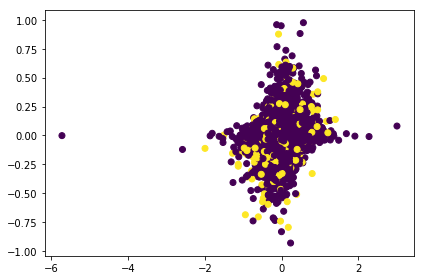

In [19]:
plt.scatter(tewhey_snp_info["LogSkew.Comb"], tewhey_snp_info["Predicted.skew"], c = tewhey_snp_info["Num.Overlaps.GM.peaks"]>0)
print(pearsonr(np.nan_to_num(tewhey_snp_info["LogSkew.Comb"]), tewhey_snp_info["Predicted.skew"]))
print(spearmanr(np.nan_to_num(tewhey_snp_info["LogSkew.Comb"]), tewhey_snp_info["Predicted.skew"]))

In [20]:
tewhey_snp_info_sig = tewhey_snp_info[tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_sig = tewhey_snp_info_sig[np.absolute(tewhey_snp_info_sig["LogSkew.Comb"])>0.5]
print(sum(np.sign(tewhey_snp_info_sig["LogSkew.Comb"]) == np.sign(np.log2(tewhey_snp_info_sig["Alt.score"]) - np.log2(tewhey_snp_info_sig["Ref.score"]))))
print(sum(np.sign(tewhey_snp_info_sig["LogSkew.Comb"]) != np.sign(np.log2(tewhey_snp_info_sig["Alt.score"]) - np.log2(tewhey_snp_info_sig["Ref.score"]))))

256
135


(0.40486596693582405, 7.437804133433271e-17)
SpearmanrResult(correlation=0.42883501226577597, pvalue=6.364154780560608e-19)


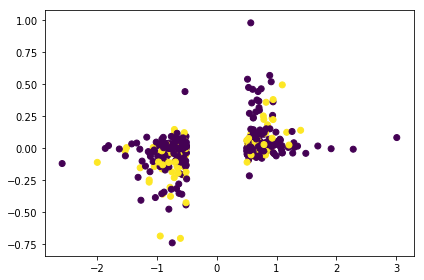

In [21]:
plt.scatter(tewhey_snp_info_sig["LogSkew.Comb"], tewhey_snp_info_sig["Predicted.skew"], c= tewhey_snp_info_sig["Num.Overlaps.GM.peaks"]>0)
print(pearsonr(np.nan_to_num(tewhey_snp_info_sig["LogSkew.Comb"]), tewhey_snp_info_sig["Predicted.skew"]))
print(spearmanr(np.nan_to_num(tewhey_snp_info_sig["LogSkew.Comb"]), tewhey_snp_info_sig["Predicted.skew"]))

In [22]:
tewhey_snp_info_pos = tewhey_snp_info[tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_pos = tewhey_snp_info_pos[tewhey_snp_info_pos["LogSkew.Comb"]>0.5]

tewhey_snp_info_neg = tewhey_snp_info[tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_neg = tewhey_snp_info_neg[tewhey_snp_info_neg["LogSkew.Comb"]< -0.5]


tewhey_snp_info_neutral = tewhey_snp_info[tewhey_snp_info["C.Skew.fdr"] < -np.log10(0.05)]
tewhey_snp_info_neutral = tewhey_snp_info_neutral[np.absolute(tewhey_snp_info_neutral["LogSkew.Comb"]) < 0.5]

Ttest_1sampResult(statistic=-6.619369494700892, pvalue=3.1525058788964767e-10)
Ttest_1sampResult(statistic=0.7633079514924175, pvalue=0.44533514697540044)
Ttest_1sampResult(statistic=6.337060020658574, pvalue=1.722408850816145e-09)
Ttest_indResult(statistic=-6.679361805633572, pvalue=2.135099039034118e-10)
Ttest_indResult(statistic=6.231843778930636, pvalue=2.8933254255031088e-09)


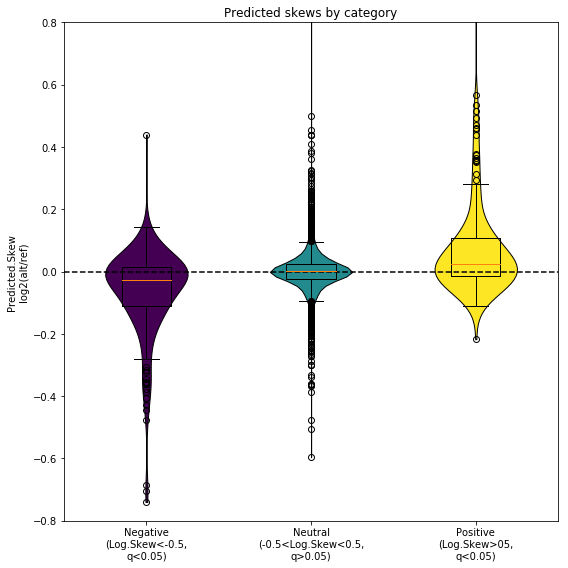

In [23]:
fig, ax = plt.subplots(figsize=(8,8))

parts = ax.violinplot(dataset=[tewhey_snp_info_neg["Predicted.skew"].tolist(), tewhey_snp_info_neutral["Predicted.skew"].tolist(), tewhey_snp_info_pos["Predicted.skew"].tolist()],showmedians=False,showextrema=False)

parts['bodies'][0].set_facecolor('#440154FF')
parts['bodies'][0].set_edgecolor('black')
parts['bodies'][0].set_alpha(1)

parts['bodies'][1].set_facecolor('#238A8DFF')
parts['bodies'][1].set_edgecolor('black')
parts['bodies'][1].set_alpha(1)    


parts['bodies'][2].set_facecolor('#FDE725FF')
parts['bodies'][2].set_edgecolor('black')
parts['bodies'][2].set_alpha(1)   

plt.boxplot([tewhey_snp_info_neg["Predicted.skew"].tolist(), tewhey_snp_info_neutral["Predicted.skew"].tolist(), tewhey_snp_info_pos["Predicted.skew"].tolist()])
plt.axhline(y=0, c='k', linestyle='--')
plt.xticks(ticks = range(1,4), labels = ["Negative\n(Log.Skew<-0.5,\nq<0.05)", "Neutral\n(-0.5<Log.Skew<0.5,\nq>0.05)", "Positive\n(Log.Skew>05,\nq<0.05)"], horizontalalignment="center")
plt.ylabel("Predicted.Skew\nlog2(alt/ref)")
plt.title("Predicted skews by category")
plt.ylim([-0.8,0.8])
print(ttest_1samp(tewhey_snp_info_neg["Predicted.skew"].tolist(),0))
print(ttest_1samp(tewhey_snp_info_neutral["Predicted.skew"].tolist(),0))
print(ttest_1samp(tewhey_snp_info_pos["Predicted.skew"].tolist(),0))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_neg["Predicted.skew"]),
                     np.std(tewhey_snp_info_neg["Predicted.skew"]),
                     len(tewhey_snp_info_neg["Predicted.skew"].tolist()),
                     np.mean(tewhey_snp_info_neutral["Predicted.skew"]),
                     np.std(tewhey_snp_info_neutral["Predicted.skew"]),
                     len(tewhey_snp_info_neutral["Predicted.skew"].tolist()),
                     equal_var=False))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_pos["Predicted.skew"]),
                     np.std(tewhey_snp_info_pos["Predicted.skew"]),
                     len(tewhey_snp_info_pos["Predicted.skew"].tolist()),
                     np.mean(tewhey_snp_info_neutral["Predicted.skew"]),
                     np.std(tewhey_snp_info_neutral["Predicted.skew"]),
                     len(tewhey_snp_info_neutral["Predicted.skew"].tolist()),
                     equal_var=False))

In [24]:
tewhey_snp_info_overlapping_peaks = tewhey_snp_info[tewhey_snp_info["Num.Overlaps.GM.peaks"]>0]
tewhey_snp_info_pos = tewhey_snp_info_overlapping_peaks[tewhey_snp_info_overlapping_peaks["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_pos = tewhey_snp_info_pos[tewhey_snp_info_pos["LogSkew.Comb"]>0.5]

tewhey_snp_info_neg = tewhey_snp_info_overlapping_peaks[tewhey_snp_info_overlapping_peaks["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_neg = tewhey_snp_info_neg[tewhey_snp_info_neg["LogSkew.Comb"]< -0.5]


tewhey_snp_info_neutral = tewhey_snp_info_overlapping_peaks[tewhey_snp_info_overlapping_peaks["C.Skew.fdr"] < -np.log10(0.05)]
tewhey_snp_info_neutral = tewhey_snp_info_neutral[np.absolute(tewhey_snp_info_neutral["LogSkew.Comb"]) < 0.5]

Ttest_1sampResult(statistic=-4.947448747304408, pvalue=8.275109094523404e-06)
Ttest_1sampResult(statistic=0.8377606192985637, pvalue=0.4024735679392296)
Ttest_1sampResult(statistic=3.5670136927234046, pvalue=0.0010190442257116343)
Ttest_indResult(statistic=-5.061745856400244, pvalue=5.175601548444353e-06)
Ttest_indResult(statistic=3.457148231764504, pvalue=0.001344600176400189)


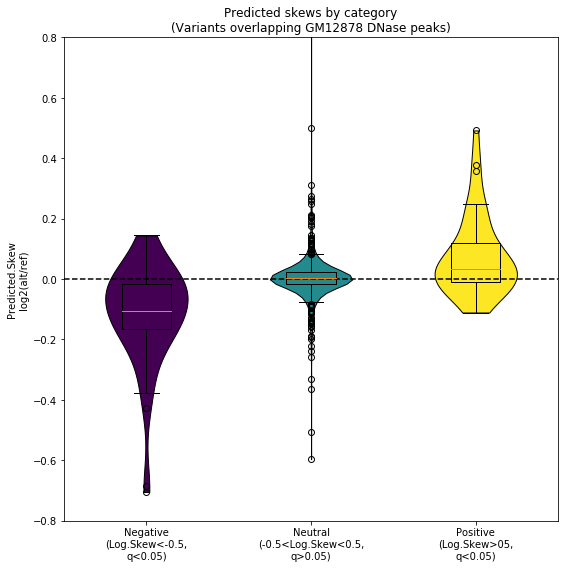

In [25]:
fig, ax = plt.subplots(figsize=(8,8))

parts = ax.violinplot(dataset=[tewhey_snp_info_neg["Predicted.skew"].tolist(), tewhey_snp_info_neutral["Predicted.skew"].tolist(), tewhey_snp_info_pos["Predicted.skew"].tolist()],showmedians=False,showextrema=False)

parts['bodies'][0].set_facecolor('#440154FF')
parts['bodies'][0].set_edgecolor('black')
parts['bodies'][0].set_alpha(1)

parts['bodies'][1].set_facecolor('#238A8DFF')
parts['bodies'][1].set_edgecolor('black')
parts['bodies'][1].set_alpha(1)    


parts['bodies'][2].set_facecolor('#FDE725FF')
parts['bodies'][2].set_edgecolor('black')
parts['bodies'][2].set_alpha(1)   

plt.boxplot([tewhey_snp_info_neg["Predicted.skew"].tolist(), tewhey_snp_info_neutral["Predicted.skew"].tolist(), tewhey_snp_info_pos["Predicted.skew"].tolist()])
plt.axhline(y=0, c='k', linestyle='--')
plt.xticks(ticks = range(1,4), labels = ["Negative\n(Log.Skew<-0.5,\nq<0.05)", "Neutral\n(-0.5<Log.Skew<0.5,\nq>0.05)", "Positive\n(Log.Skew>05,\nq<0.05)"], horizontalalignment="center")
plt.ylabel("Predicted.Skew\nlog2(alt/ref)")
plt.title("Predicted skews by category\n(Variants overlapping GM12878 DNase peaks)")
plt.ylim([-0.8,0.8])
print(ttest_1samp(tewhey_snp_info_neg["Predicted.skew"].tolist(),0))
print(ttest_1samp(tewhey_snp_info_neutral["Predicted.skew"].tolist(),0))
print(ttest_1samp(tewhey_snp_info_pos["Predicted.skew"].tolist(),0))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_neg["Predicted.skew"]),
                     np.std(tewhey_snp_info_neg["Predicted.skew"]),
                     len(tewhey_snp_info_neg["Predicted.skew"].tolist()),
                     np.mean(tewhey_snp_info_neutral["Predicted.skew"]),
                     np.std(tewhey_snp_info_neutral["Predicted.skew"]),
                     len(tewhey_snp_info_neutral["Predicted.skew"].tolist()),
                     equal_var=False))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_pos["Predicted.skew"]),
                     np.std(tewhey_snp_info_pos["Predicted.skew"]),
                     len(tewhey_snp_info_pos["Predicted.skew"].tolist()),
                     np.mean(tewhey_snp_info_neutral["Predicted.skew"]),
                     np.std(tewhey_snp_info_neutral["Predicted.skew"]),
                     len(tewhey_snp_info_neutral["Predicted.skew"].tolist()),
                     equal_var=False))

In [168]:
X_train = np.load('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/chrs_training_summit_centered_training_set_hg19_X.npy')
Y_train = np.load('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/chrs_training_summit_centered_training_set_hg19_Y.npy')
X_valid = np.load('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/chr4_summit_centered_validation_set_hg19_X.npy')
Y_valid = np.load('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/chr4_summit_centered_validation_set_hg19_Y.npy')

In [169]:
pred_train = model_11_hg19.predict(X_train)
pred_valid = model_11_hg19.predict(X_valid)

Training: (array([0.75791571]), array([0.]))
Training: SpearmanrResult(correlation=0.7674512528330918, pvalue=0.0)


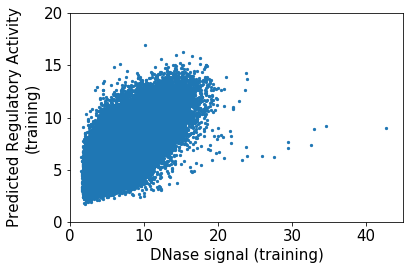

In [187]:

plt.scatter(Y_train, pred_train, s=5)
plt.xlabel("DNase signal (training)")
plt.ylabel("Predicted Regulatory Activity\n(training)")
plt.xlim([0,45])
plt.ylim([0,20])

plt.savefig("gm_model_training_chr_prediction.svg")

print("Training:",pearsonr(Y_train, pred_train))
print("Training:",spearmanr(Y_train, pred_train))


Validation: (array([0.6884696]), array([0.]))
Validation: SpearmanrResult(correlation=0.6987954068549386, pvalue=0.0)


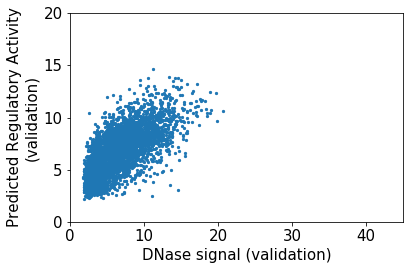

In [188]:
plt.scatter(Y_valid, pred_valid, s=5)
plt.xlabel("DNase signal (validation)")
plt.ylabel("Predicted Regulatory Activity\n(validation)")
plt.xlim([0,45])
plt.ylim([0,20])


plt.savefig("gm_model_held_out_chr_prediction.svg")

print("Validation:",pearsonr(Y_valid, pred_valid))
print("Validation:",spearmanr(Y_valid, pred_valid))